In [1]:
import json 
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [29]:
bits = "4" # "8" or "4"
model_name = ["mistralai/Mixtral-8x22B-Instruct-v0.1","01-ai/Yi-1.5-9B-Chat","mistralai/Mixtral-8x7B-Instruct-v0.1","Qwen/Qwen1.5-7B-Chat","meta-llama/Meta-Llama-3-8B-Instruct"]
i = 0

results=[]
coverage_raw=[]


with open("./scripts/gridout_"+bits+"bit_"+"_".join(model_name[4].split("/"))+".jsonl", "r") as f:
    for idx, line in enumerate(f):
        line = json.loads(line)
        if idx%50==0:
            results.append(line)
        coverage_raw.append(len(line["aligned_output"])/len(line["whole_input"]))

coverage_all = [[] for i in range(int(len(coverage_raw)/50))]
coverage_avg = []

for i in range(int(len(coverage_raw)/50)):
    for j in range(50):
        coverage_all[i].append(coverage_raw[i*50+j])

coverage_avg = [sum(elt)/len(elt) for elt in coverage_all]

In [30]:
print(coverage_avg)

[0.6876349178658617, 0.6557511127107643, 0.5763211853640214, 0.680482509566385, 0.687372342134282, 0.43527049071976165, 0.7100490588482056, 0.6974543349463466, 0.5297581133580045, 0.6790977355696642, 0.6998261033407193, 0.04709807004404171, 0.6251033048140975, 0.13457020620653426, 0.6553747305487815, 0.36925320467346545, 0.6705710053558697, 0.4423027162964442, 0.6691734983785367, 0.3689122534990018, 0.6203287947507204, 0.6329229662666829, 0.6875875926690023, 0.48329449875228614, 0.6018189015672687, 0.6332670806916892, 0.23001009223029542, 0.5186711674426747, 0.6856461572499208, 0.44462082547129583, 0.4066937961312589, 0.5893789466189115, 0.566604821162875, 0.5831343426082387, 0.2391571628353994, 0.6609256683851771, 0.7007484544079958, 0.5269710399285006, 0.6950060281869511, 0.5781811850373463, 0.6896069277880502, 0.4083965168779256]


In [3]:
time = []
tokens = []
coverage = []
wer = []
window_size = []
do_sample=[]
beam_search=[]
num_beams=[]
temperature=[]

y = []

lowest_score = 1
lowest_score_index = 0

for index, elt in enumerate(results):
    time.append(elt["time taken"])
    tokens.append(elt["total tokens generated"])
    coverage.append(elt["scores"]["percentage_found"])
    wer.append(elt["scores"]["hf_wer"])
    do_sample.append(elt["parameters"]["do_sample"])

    if elt["scores"]["hf_wer"] < lowest_score:
        lowest_score = elt["scores"]["hf_wer"]
        lowest_score_index = index

    try:
        beam_search.append(elt["parameters"]["beam_search"])
    except:
        beam_search.append(False)

    try:
        num_beams.append(elt["parameters"]["num_beams"])
    except:
        num_beams.append(0)
        
    try:
        temperature.append(elt["parameters"]["temperature"])
    except:
        temperature.append(0)
        
    window_size.append(elt["parameters"]["window_size"])
    y.append(elt["total tokens generated"]/elt["time taken"])

print("lowest score at index:", index)

lowest score at index: 41


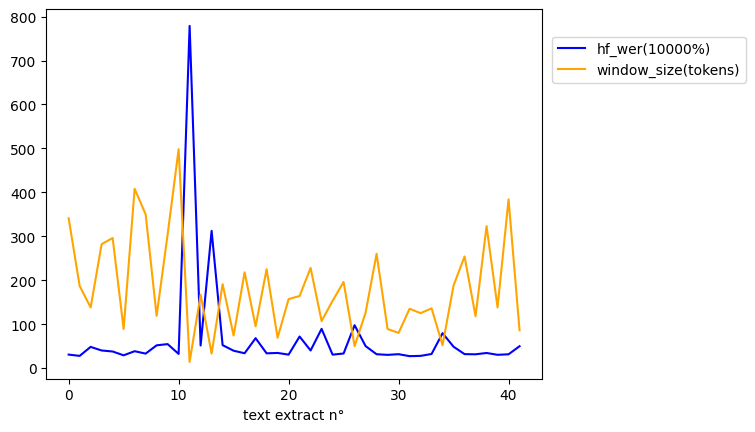

In [4]:
x = [i for i in range(len(time))]

sigma = 10 
window_size_smooth = window_size
wer_smooth =wer

plt.plot(x, [elt*1000 for elt in wer_smooth], color="blue", label="hf_wer(10000%)")
plt.plot(x, window_size_smooth, color="orange", label="window_size(tokens)")
plt.xlabel("text extract n°")
plt.legend(loc=(1.02, 0.8))
plt.show()

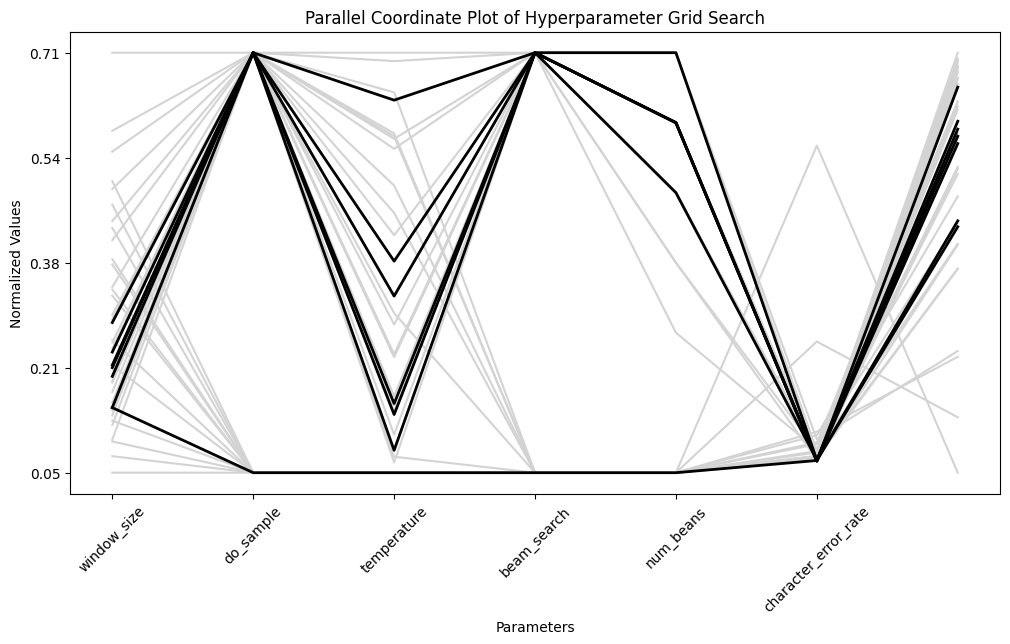

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample data representing the hyperparameter grid search results
data = {
    'window_size': window_size,
    'do_sample': do_sample,
    'temperature': temperature,
    'beam_search': beam_search,
    'num_beans': num_beams, 
    'character_error_rate': wer, 
    'coverage': coverage_avg
}


# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Normalize the data for plotting purposes
df_normalized = df.copy()
for column in df_normalized.columns:
    if df_normalized[column].dtype != bool and column != 'character_error_rate':
        df_normalized[column] = (df_normalized[column] - df_normalized[column].min()) / (df_normalized[column].max() - df_normalized[column].min())

# Define a function to convert boolean to int for plotting
df_normalized['do_sample'] = df_normalized['do_sample'].astype(int)
df_normalized['beam_search'] = df_normalized['beam_search'].astype(int)

# Sort the DataFrame based on character error rate
df_sorted = df_normalized.sort_values(by='character_error_rate')

# Split the DataFrame into two parts
df_grey = df_sorted[7:]
df_black = df_sorted[:7]

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the grey lines first
for i in range(len(df_grey)):
    ax.plot(df_grey.columns, df_grey.iloc[i], color='lightgrey')

# Plot the black lines on top
for i in range(len(df_black)):
    ax.plot(df_black.columns, df_black.iloc[i], color='black', linewidth=2)

# Customize the axis labels to show actual values
for i, column in enumerate(df.columns):
    values = df[column]
    normalized_values = df_normalized[column]
    tick_positions = np.linspace(normalized_values.min(), normalized_values.max(), num=5)
    tick_labels = np.linspace(values.min(), values.max(), num=5)
    ax.set_xticks(np.arange(len(df.columns) - 1))
    ax.set_xticklabels(df.columns[:-1], rotation=45)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels([f"{label:.2f}" for label in tick_labels])

# Label the plot
plt.title('Parallel Coordinate Plot of Hyperparameter Grid Search')
plt.xlabel('Parameters')
plt.ylabel('Normalized Values')

plt.show()


In [38]:
print(df_black)

    window_size  do_sample  temperature  beam_search  num_beans  \
31     0.250000          1     0.164586            1   0.833333   
1      0.357438          1     0.886972            1   0.833333   
32     0.229339          1     0.138473            1   0.833333   
5      0.154959          0     0.000000            0   0.000000   
29     0.154959          1     0.053342            1   0.833333   
39     0.256198          1     0.503695            1   1.000000   
24     0.287190          1     0.420468            1   0.666667   

    character_error_rate  coverage  
31              0.027118  0.817980  
1               0.027736  0.918097  
32              0.027750  0.783628  
5               0.029036  0.585522  
29              0.030062  0.599626  
39              0.030207  0.801090  
24              0.030546  0.836745  


/usr/local/lib64/python3.9/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (42). n_quantiles is set to n_samples.
  warnings.warn(


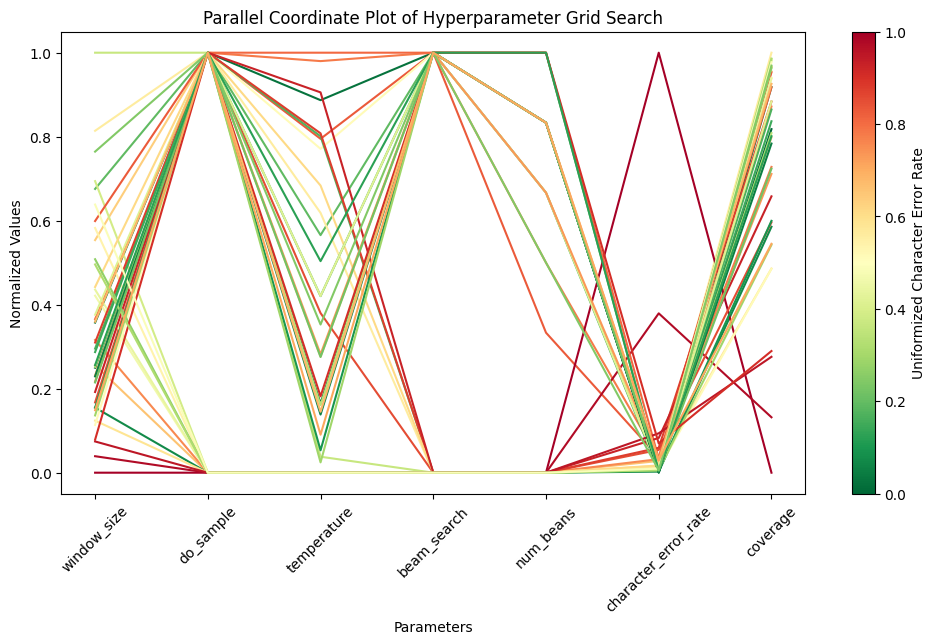

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import QuantileTransformer
import matplotlib.colors as mcolors
# Sample data representing the hyperparameter grid search results
data = {
    'window_size': window_size,
    'do_sample': do_sample,
    'temperature': temperature,
    'beam_search': beam_search,
    'num_beans': num_beams, 
    'character_error_rate': wer, 
    'coverage': coverage_avg
}


# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Normalize the data (excluding boolean columns) for better visualization
for column in df.columns:
    if df[column].dtype != bool:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

# Define a function to convert boolean to int for plotting
df_normalized['do_sample'] = df_normalized['do_sample'].astype(int)
df_normalized['beam_search'] = df_normalized['beam_search'].astype(int)


# Use QuantileTransformer to normalize the character error rate
quantile_transformer = QuantileTransformer(output_distribution='uniform')
df['character_error_rate_normalized'] = quantile_transformer.fit_transform(df[['character_error_rate']])

# Determine the colors based on the normalized character error rate
norm = plt.Normalize(df['character_error_rate_normalized'].min(), df['character_error_rate_normalized'].max())
colors = plt.cm.RdYlGn_r(norm(df['character_error_rate_normalized']))

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the parallel coordinates
for i in range(len(df)):
    ax.plot(df.columns[:-1], df.iloc[i, :-1], color=colors[i])

# Add colorbar for reference
sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Uniformized Character Error Rate')

# Label the axes
plt.xticks(rotation=45)
plt.title('Parallel Coordinate Plot of Hyperparameter Grid Search')
plt.xlabel('Parameters')
plt.ylabel('Normalized Values')

plt.show()
